# Experience Study MVP (Lapse) — Starter Notebook

Compute crude lapse rates by duration and apply a simple Bühlmann-Straub credibility blend.

**Outputs:** CSV tables + PNG charts in `../results/`

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("../data")
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

panel = pd.read_csv(DATA_DIR / "synthetic_policy_months.csv")
panel.head()


,policy_id,duration_month,exposure,termination_lapse,termination_death,risk_class,gender,product
0,1,1,1.0,0,0,Standard,F,Term20
1,1,2,1.0,0,0,Standard,F,Term20
2,1,3,1.0,0,0,Standard,F,Term20
3,1,4,1.0,0,0,Standard,F,Term20
4,1,5,1.0,0,0,Standard,F,Term20


In [2]:

grp = panel.groupby("duration_month").agg(
    exposure=("exposure", "sum"),
    lapses=("termination_lapse", "sum")
).reset_index()
grp["crude_lapse_rate"] = grp["lapses"] / grp["exposure"]
grp.to_csv(RESULTS_DIR / "lapse_rates_by_duration.csv", index=False)
grp.head(12)


,duration_month,exposure,lapses,crude_lapse_rate
0,1,7871.5,254,0.032268
1,2,7662.5,158,0.020620
2,3,7510.5,135,0.017975
3,4,7389.5,95,0.012856
4,5,7286.5,101,0.013861
5,6,7199.0,64,0.008890
6,7,7127.5,69,0.009681
7,8,7058.0,59,0.008359
8,9,6999.5,46,0.006572
9,10,6947.0,45,0.006478


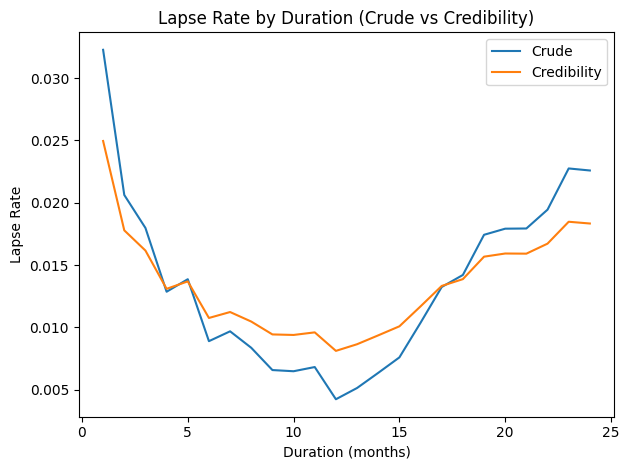

In [3]:

k = 5000.0
overall = panel["termination_lapse"].sum() / panel["exposure"].sum()
grp["Z"] = grp["exposure"] / (grp["exposure"] + k)
grp["cred_lapse_rate"] = grp["Z"] * grp["crude_lapse_rate"] + (1 - grp["Z"]) * overall

grp.to_csv(RESULTS_DIR / "lapse_rates_by_duration_cred.csv", index=False)

plt.figure()
plt.plot(grp["duration_month"], grp["crude_lapse_rate"], label="Crude")
plt.plot(grp["duration_month"], grp["cred_lapse_rate"], label="Credibility")
plt.title("Lapse Rate by Duration (Crude vs Credibility)")
plt.xlabel("Duration (months)")
plt.ylabel("Lapse Rate")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "lapse_curve.png", dpi=150)
plt.show()


/var/folders/nw/kh2n3_zx50n_p1t964gvg_mc0000gn/T/ipykernel_39249/589600913.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall_by_rc = dim.groupby("risk_class").apply(lambda df: df["lapses"].sum() / df["exposure"].sum()).to_dict()


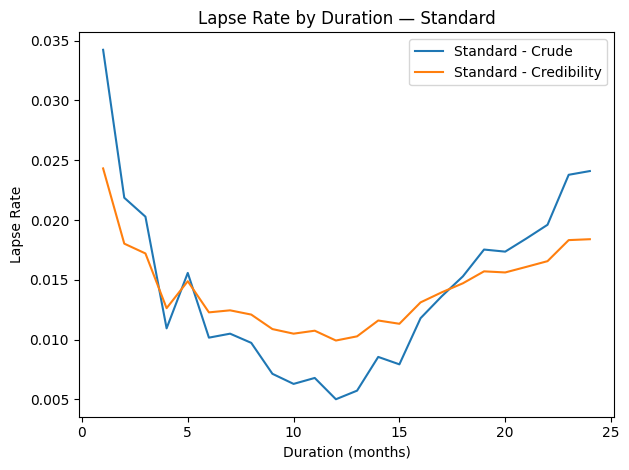

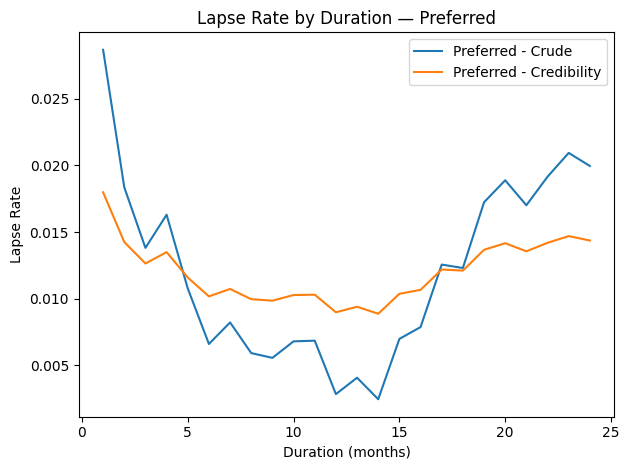

In [4]:

dim = panel.groupby(["duration_month", "risk_class"]).agg(
    exposure=("exposure", "sum"),
    lapses=("termination_lapse", "sum")
).reset_index()
dim["crude_lapse_rate"] = dim["lapses"] / dim["exposure"]
overall_by_rc = dim.groupby("risk_class").apply(lambda df: df["lapses"].sum() / df["exposure"].sum()).to_dict()
k = 5000.0
dim["Z"] = dim["exposure"] / (dim["exposure"] + k)
dim["overall_rc"] = dim["risk_class"].map(overall_by_rc)
dim["cred_lapse_rate"] = dim["Z"] * dim["crude_lapse_rate"] + (1 - dim["Z"]) * dim["overall_rc"]
dim.to_csv(RESULTS_DIR / "lapse_rates_by_duration_risk.csv", index=False)

for rc in ["Standard", "Preferred"]:
    sub = dim[dim["risk_class"] == rc].sort_values("duration_month")
    plt.figure()
    plt.plot(sub["duration_month"], sub["crude_lapse_rate"], label=f"{rc} - Crude")
    plt.plot(sub["duration_month"], sub["cred_lapse_rate"], label=f"{rc} - Credibility")
    plt.title(f"Lapse Rate by Duration — {rc}")
    plt.xlabel("Duration (months)")
    plt.ylabel("Lapse Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"lapse_curve_{rc.lower()}.png", dpi=150)
    plt.show()
